/tmp/ipython-input-3662937439.py:27: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2[date_col] = pd.to_datetime(df2[date_col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3662937439.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2[date_col] = pd.to_datetime(df2[date_col], errors="coerce", infer_datetime_format=True)


NameError: name 'OUT_DIR' is not defined

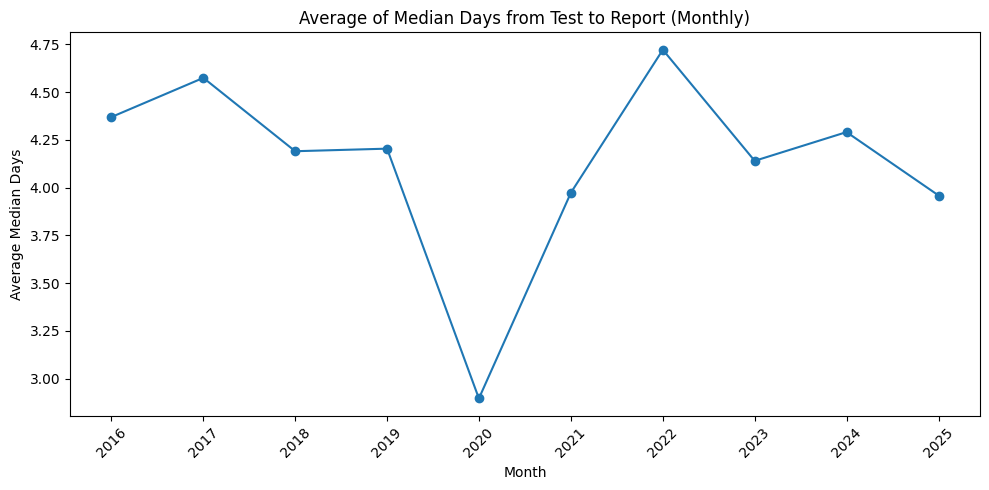

In [1]:
# === Testreport_timeseries: monthly average + region-name fill via provider ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# ---------- LOAD ----------
df_raw2 = pd.read_csv("/content/Testreport_timeseries.csv")
df2 = df_raw2.rename(columns=lambda x: x.strip().replace(" ", "_").lower()).copy()

# Expecting these columns (from your file): region, regionname, org_code, provider_name, date, median_days_test_to_report
date_col = "date" if "date" in df2.columns else None
if date_col is None:
    # fallback detection
    best_cov = -1; parsed_date = None; chosen = None
    for c in df2.columns:
        if pd.api.types.is_numeric_dtype(df2[c]): continue
        p = pd.to_datetime(df2[c], errors="coerce", infer_datetime_format=True)
        cov = p.notna().mean()
        if cov > best_cov and p.nunique(dropna=True) >= 3:
            best_cov, parsed_date, chosen = cov, p, c
    if chosen is None:
        raise ValueError("Could not detect a date column in Testreport_timeseries.")
    df2["__date__"] = parsed_date
    date_col = "__date__"
else:
    df2[date_col] = pd.to_datetime(df2[date_col], errors="coerce", infer_datetime_format=True)

# detect value col
val_col = next(
    (c for c in df2.columns if "median" in c and "day" in c and "report" in c),
    None
)
if val_col is None:
    # fallback: choose a numeric with good name
    num_cols = [c for c in df2.columns if pd.api.types.is_numeric_dtype(df2[c])]
    if not num_cols:
        raise ValueError("No numeric column found for test-to-report median days.")
    val_col = num_cols[0]

df2[val_col] = pd.to_numeric(df2[val_col], errors="coerce")

tidy2 = df2.loc[:, [date_col, val_col]].rename(columns={date_col:"date", val_col:"median_days"}).dropna()
tidy2 = tidy2.sort_values("date")

# ----- Monthly average line chart -----
monthly_avg2 = tidy2.assign(year_month=tidy2["date"].dt.to_period("M").dt.to_timestamp())
monthly_avg2 = monthly_avg2.groupby("year_month")["median_days"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg2["year_month"], monthly_avg2["median_days"], marker="o")
plt.title("Average of Median Days from Test to Report (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Median Days")
plt.xticks(rotation=45)
plt.tight_layout()
out_monthly_png2 = OUT_DIR / "test_to_report_monthly_avg.png"
plt.savefig(out_monthly_png2, dpi=200, bbox_inches="tight")
plt.close()

# ----- Replace region codes with names via provider mapping -----
provider_col = "provider_name" if "provider_name" in df2.columns else None
region_name_col = "regionname" if "regionname" in df2.columns else None
region_code_col = "region" if "region" in df2.columns else None

if provider_col:
    if not region_name_col:
        # create placeholder names from codes if needed
        region_name_col = "regionname"
        df2[region_name_col] = df2[region_code_col] if region_code_col else pd.NA

    provider_to_regionname = (
        df2.dropna(subset=[region_name_col])
           .groupby(provider_col)[region_name_col]
           .agg(lambda x: x.mode()[0] if len(x.mode())>0 else x.iloc[0])
           .to_dict()
    )

    # Fill
    df2[region_name_col] = df2.apply(
        lambda r: provider_to_regionname.get(r[provider_col], r[region_name_col]),
        axis=1
    )

    # Average per region (with full names)
    avg_region_named = (
        df2.groupby(region_name_col)[val_col]
           .mean()
           .reset_index()
           .rename(columns={val_col:"average_median_days"})
           .sort_values("average_median_days")
    )

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(avg_region_named[region_name_col], avg_region_named["average_median_days"])
    plt.xlabel("Average Median Days")
    plt.title("Average Median Days from Test to Report by Region (names)")
    plt.tight_layout()
    out_region_png2 = OUT_DIR / "test_to_report_region_names_avg.png"
    plt.savefig(out_region_png2, dpi=200, bbox_inches="tight")
    plt.close()

    # Optional CSV
    avg_region_named.to_csv(OUT_DIR / "test_to_report_region_names_avg.csv", index=False)

# ----- Optional: save the monthly table -----
monthly_avg2.to_csv(OUT_DIR / "test_to_report_monthly_avg.csv", index=False)

print("Saved:", out_monthly_png2)
if provider_col:
    print("Region averages image:", OUT_DIR / "test_to_report_region_names_avg.png")


/tmp/ipython-input-1750045786.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2[date_col2] = pd.to_datetime(df2[date_col2], errors="coerce", dayfirst=True)


Dtypes:
 date                          datetime64[ns]
median_days_test_to_report           float64
regionname                            object
dtype: object 

Null counts:
 date                             0
median_days_test_to_report     499
regionname                    4974
dtype: int64 

Regional averages (first 10 rows):
                                       regionname  median_days_test_to_report
6                South West Commissioning Region                    2.955752
5                South East Commissioning Region                    3.622518
0          East of England Commissioning Region                     3.709373
3  North East and Yorkshire Commissioning Region                    3.774415
2                 Midlands Commissioning Region                     4.404798
7                                            NaN                    4.415898
1                    London Commissioning Region                    4.665257
4                North West Commissioning Region      

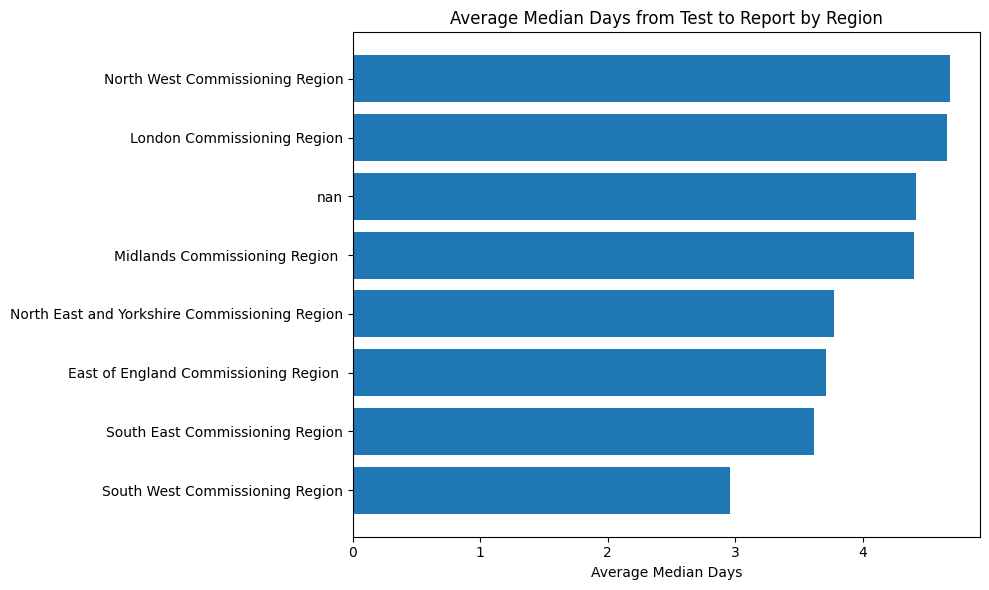

Chart saved to: /content/test_to_report_region_avg.png


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load & standardize ---
df2 = pd.read_csv("/content/Testreport_timeseries.csv")  # <-- change path if needed
df2 = df2.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# Key columns
region_col2 = "regionname" if "regionname" in df2.columns else "region"
date_col2   = "date"
value_col2  = "median_days_test_to_report"   # <-- the numeric column we need

# --- Parse dates (remove deprecated arg, optionally set dayfirst=True if your dates are DD/MM/YY) ---
df2[date_col2] = pd.to_datetime(df2[date_col2], errors="coerce", dayfirst=True)

# --- Clean & convert value column to numeric ---
# Remove anything that isn't 0-9, dot, or minus (e.g., commas, spaces, footnotes)
df2[value_col2] = (
    df2[value_col2]
      .astype(str)
      .str.replace(r"[^\d\.\-]", "", regex=True)
)
df2[value_col2] = pd.to_numeric(df2[value_col2], errors="coerce")

# Keep only the columns we need and drop rows missing date/value
tidy2 = df2[[date_col2, value_col2, region_col2]].dropna(subset=[date_col2, value_col2])

# --- Average per region (across full period) ---
avg_region2 = (
    tidy2.groupby(region_col2, dropna=False)[value_col2]
         .mean()
         .reset_index()
         .sort_values(value_col2)
)

print("Dtypes:\n", df2[[date_col2, value_col2, region_col2]].dtypes, "\n")
print("Null counts:\n", df2[[date_col2, value_col2, region_col2]].isna().sum(), "\n")
print("Regional averages (first 10 rows):\n", avg_region2.head(10))

# --- Plot bar chart ---
plt.figure(figsize=(10, 6))
plt.barh(avg_region2[region_col2].astype(str), avg_region2[value_col2])
plt.xlabel("Average Median Days")
plt.title("Average Median Days from Test to Report by Region")
plt.tight_layout()

out_path = Path("/content/test_to_report_region_avg.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Chart saved to:", out_path)
